In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from bertscore import BERTScore  # noqa: F401
from common import Evaluator
from conventional_metrics import BLEU, METEOR  # noqa: F401
from ood_metrics import SyntacticCompositionality  # noqa: F401
from scm import SCM, ContextualSCM, DecontextualizedSCM  # noqa: F401
from wmd import WMD, ContextualWMD, DecontextualizedWMD  # noqa: F401

/home/xstefan3/miniconda3/envs/new_hf/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
from pathlib import Path

if not (Path('embeddings')/'cc.en.300.bin').exists():
    %mkdir -p embeddings
    ! wget -nc https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -O embeddings/cc.en.300.bin.gz
    ! gzip -d embeddings/cc.en.300.bin.gz

### Mutual correlations of metrics

In [3]:
JUDGEMENTS_TYPE = "MQM"
NO_REFERENCE = True

reports = []

langs = Evaluator.langs_for_judgements(JUDGEMENTS_TYPE)

for lang_pair in langs:
    src_lang, tgt_lang = lang_pair.split("-")
    metrics = [
        # # SyntacticCompositionality needs PoS tagger, that can be automatically resolved only for some langs:
        # # https://spacy.io/models
        SyntacticCompositionality(tgt_lang=tgt_lang, src_lang=src_lang, reference_free=NO_REFERENCE),
        ContextualWMD(tgt_lang=tgt_lang, reference_free=NO_REFERENCE),
        BERTScore(tgt_lang=tgt_lang, reference_free=NO_REFERENCE),
        # ContextualSCM(tgt_lang=tgt_lang, reference_free=NO_REFERENCE),
        DecontextualizedSCM(tgt_lang=tgt_lang, use_tfidf=False, reference_free=NO_REFERENCE),
        DecontextualizedSCM(tgt_lang=tgt_lang, use_tfidf=True, reference_free=NO_REFERENCE),
        DecontextualizedWMD(tgt_lang=tgt_lang, use_tfidf=False, reference_free=NO_REFERENCE),
        DecontextualizedWMD(tgt_lang=tgt_lang, use_tfidf=True, reference_free=NO_REFERENCE),
    ]

    print("Evaluating lang pair %s" % lang_pair)
    evaluator = Evaluator("data_dir", lang_pair, metrics,
                          judgements_type=JUDGEMENTS_TYPE, reference_free=NO_REFERENCE, firstn=1000)
    report = evaluator.evaluate()
    reports.append(report)

    pearson = pd.DataFrame(report).applymap(float).corr(method="pearson").applymap(abs)
    sns.heatmap(pearson, annot=True)
    plt.tight_layout()
    plt.show()
    
    spearman = pd.DataFrame(report).applymap(float).corr(method="spearman").applymap(abs)
    sns.heatmap(spearman, annot=True)
    plt.show()

Evaluating lang pair zh-en


WMD_contextual: construct contextual embeddings:   0%|          | 0/2000 [00:00<?, ?it/s]

SCM_decontextualized: construct decontextualized embeddings:   0%|          | 0/1443 [00:00<?, ?it/s]

100%|██████████| 1443/1443 [00:05<00:00, 252.10it/s]


SCM_decontextualized_tfidf: construct decontextualized embeddings:   0%|          | 0/1443 [00:00<?, ?it/s]

100%|██████████| 1443/1443 [00:05<00:00, 241.70it/s]


WMD_decontextualized: construct decontextualized embeddings:   0%|          | 0/1443 [00:00<?, ?it/s]

WMD_decontextualized_tfidf: construct decontextualized embeddings:   0%|          | 0/1443 [00:00<?, ?it/s]


✘ No compatible model found for 'zh_core_web_trf' (spaCy v2.3.5).



ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/xstefan3/mt-eval/ood_metrics.py", line 69, in _init_tagger
    spacy_tagger = spacy.load(model_id)
  File "/home/xstefan3/miniconda3/envs/new_hf/lib/python3.8/site-packages/spacy/__init__.py", line 30, in load
    return util.load_model(name, **overrides)
  File "/home/xstefan3/miniconda3/envs/new_hf/lib/python3.8/site-packages/spacy/util.py", line 175, in load_model
    raise IOError(Errors.E050.format(name=name))
OSError: [E050] Can't find model 'zh_core_web_trf'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/xstefan3/miniconda3/envs/new_hf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-29504d91ec5c>", line 26, in <module>
    report = evaluator.evaluate()


TypeError: object of type 'NoneType' has no len()

## Correlations of metrics to Expert Scalar Quality Metrics (eSQM): per language

<AxesSubplot:>

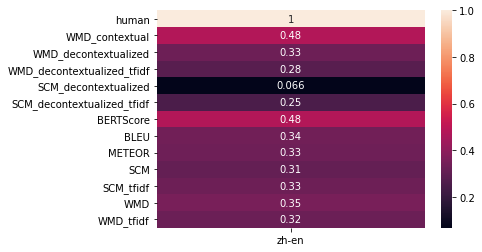

In [4]:
# Pearson
corrs_p = pd.concat([pd.DataFrame(report).corr(method="pearson").abs()["human"] for report in reports], axis=1)
corrs_p.columns = selected_lang_pairs
sns.heatmap(pd.DataFrame(corrs_p), annot=True)

<AxesSubplot:>

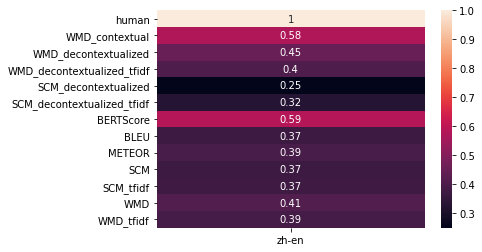

In [5]:
# Spearman
corrs_p = pd.concat([pd.DataFrame(report).corr(method="spearman").abs()["human"] for report in reports], axis=1)
corrs_p.columns = selected_lang_pairs
sns.heatmap(pd.DataFrame(corrs_p), annot=True)